In [1]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from IPython.display import display, Markdown

model = AutoModelForVision2Seq.from_pretrained("nvidia/Cosmos-Reason1-7B", dtype="auto", device_map="auto")

processor = AutoProcessor.from_pretrained("nvidia/Cosmos-Reason1-7B")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-12-16 19:01:11.610854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 19:01:15.930249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [04:04<00:00, 61.08s/it]
The image pro

In [2]:
def generate_description(prompt_text, image_path, max_new_tokens):

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_path,
                },
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0] if output_text else ""

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Table scene

In [4]:
prompt_text = """
    You are an object detection AI. Scan the image thoroughly and identify EVERY single item on the table.

    For each detected object, provide:
    1. Object type/class
    2. Primary color
    3. Size estimate (small/medium/large)
    4. Position relative to other objects (left side, right side, center, adjacent to...)

    CRITICAL: Include all objects, no matter how small or partially obscured.
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

```json
[
    {
        "name": "Desk",
        "primary_color": "white",
        "size_estimate": "small",
        "position": "center of the frame"
    },
    {
        "name": "Lamp",
        "primary_color": "white",
        "size_estimate": "small",
        "position": "left side of the desk"
    },
    {
        "name": "Calendar",
        "primary_color": "purple and white",
        "size_estimate": "medium",
        "position": "mounted on the wall above the desk"
    },
    {
        "name": "Fan",
        "primary_color": "white",
        "size_estimate": "medium",
        "position": "right side of the desk"
    },
    {
        "name": "Bottle",
        "primary_color": "black",
        "size_estimate": "small",
        "position": "far right side of the desk"
    },
    {
        "name": "Notebook",
        "primary_color": "blue and white",
        "size_estimate": "medium",
        "position": "center-left of the desk"
    },
    {
        "name": "Mouse",
        "primary_color": "black",
        "size_estimate": "small",
        "position": "right side of the desk near the fan"
    },
    {
        "name": "Pen",
        "primary_color": "blue",
        "size_estimate": "small",
        "position": "on top of the notebook"
    },
    {
        "name": "Charger",
        "primary_color": "white",
        "size_estimate": "small",
        "position": "left side of the desk next to the lamp"
    },
    {
        "name": "Cable",
        "primary_color": "black",
        "size_estimate": "medium",
        "position": "extending from the charger across the desk"
    }
]
```

In [5]:
prompt_text = """
    You are an assistant analyzing a photo of a tabletop. Your task is to list every visible object **on the table surface only** (ignore floor, walls, people).

    For each object, provide **one line** in this exact format:
    - [Object name], [main color], [size: small/medium/large], [position: left / center / right part of the table]

    Rules:
    1. Only describe objects you clearly see. If unsure about color/size — skip that detail.
    2. Do NOT invent objects, brands, or text. If no text is readable, do not mention any.
    3. Include very small items (e.g. pen, key, coin) if visible.
    4. If an object is partially hidden but identifiable, include it.
    5. Do not describe position relative to other objects (e.g. "next to cup") — use absolute position on table (left/center/right).
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

- Desk lamp, white, small, left side of the table
- Calendar, purple and white, large, mounted on the wall above the table
- Notebook, blue cover with white text, medium, center-left of the table
- Pen, blue, small, resting on the notebook
- Mouse, black, small, right side of the table
- Fan, white, small, right side of the table
- Water bottle, dark-colored, tall, far right side of the table
- Cables, black, various lengths, spread across the table
- Eraser, yellow, small, near the center of the table
- Highlighter, green, small, near the center of the table


In [6]:
prompt_text = """
    You are analyzing an image of a table with various personal items placed on it. Based on the provided description, the following objects should be present in the scene:

    Cup
    Notebook
    Pen
    Calculator
    Thermos
    Mouse
    Calendar
    Lamp
    Clock
    Two markers (green and pink)
    Power bank / charging block
    Knife
    Fan

Carefully examine the image and determine which of these items are actually visible in the scene. List all the objects that are present, and clearly indicate which ones are missing or not visible.
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

```json
{
    "Cup": false,
    "Notebook": true,
    "Pen": true,
    "Calculator": false,
    "Thermos": true,
    "Mouse": true,
    "Calendar": true,
    "Lamp": true,
    "Clock": false,
    "Two markers (green and pink)": true,
    "Power bank / charging block": true,
    "Knife": false,
    "Fan": true
}
```

In [7]:
prompt_text = """
    This image shows an indoor scene. Based ONLY on what you see, answer:

    1. Is there a container, used for storing drinks? (If yes name it — if not, write “No”)  
    2. Is there a phone on the table? (Answer: Yes / No)  
    3. Is there a device for a laptop on the table? (Answer: Yes / No)  
    4. What black items are visible on the table? (List them — if none, write “None”)  
    5. Is there a writing instrument on the table? (If yes name it — if not, write “No”)

    Do not guess. If you don’t see it clearly, answer "No".
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

1. Yes - A black water bottle is present on the right side of the desk.
2. No
3. Yes - A laptop is partially visible under some papers and books on the desk.
4. Mouse, earphones, and a small electronic device connected to the earphones are visible.
5. Yes - A blue pen is placed next to the mouse on the desk.

## Bed scene

In [8]:
prompt_text = """
    You are an object detection AI. Scan the image thoroughly and identify EVERY single item on the bed.

    For each detected object, provide:
    1. Object type/class
    2. Primary color
    3. Size estimate (small/medium/large)
    4. Position relative to other objects (left side, right side, center, adjacent to...)

    CRITICAL: Include all objects, no matter how small or partially obscured.

"""
image_path = "/home/jupyter/project/experiments/bed.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

1. Bed - The bed is a single-sized with a light blue and white patterned mattress cover. It has two pillows with green leaf patterns and a pink blanket with green leaf designs draped over it.
   - Color: Light blue and white patterned mattress cover; green leaf-patterned pillows; pink blanket with green leaf designs.
   - Size: Single-sized.
   - Position: Center of the room, against the wall.
2. Laptop - A black laptop is placed on the bed near the edge closest to the viewer.
   - Color: Black.
   - Size: Standard laptop size.
   - Position: On the bed, slightly towards the front.
3. Pillow - Two pillows with green leaf patterns are placed at the head of the bed.
   - Color: Green leaf patterns on a light background.
   - Size: Standard pillow size.
   - Position: At the head of the bed, one on each side.
4. Blanket - A pink blanket with green leaf designs is draped over the bed.
   - Color: Pink with green leaf patterns.
   - Size: Large enough to cover most of the bed.
   - Position: Draped over the bed, covering part of it.



In [9]:
prompt_text = """
    You are an assistant analyzing a photo of a bed. Your task is to list every visible object **on the bed surface only** (ignore floor, walls, people).

    For each object, provide **one line** in this exact format:  
    - [Object name], [main color], [size: small/medium/large], [position: left / center / right part of the bed]

    Rules:  
    1. Only describe objects you clearly see. If unsure about color/size — skip that detail.  
    2. Do NOT invent objects, brands, or text. If no text is readable, do not mention any.  
    3. Include very small items (e.g. plug, cable, coin) if visible.  
    4. If an object is partially hidden but identifiable, include it.  
    5. Do not describe position relative to other objects (e.g. "next to lamp") — use absolute position on table (left/center/right).

"""
image_path = "/home/jupyter/project/experiments/bed.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

- Laptop, black, medium, center-right part of the bed
- Bedspread, light pink with green leaf patterns, large, covering most of the bed
- Pillowcase, teal with swirling patterns, large, on the left side of the bed
- Pillow, white, medium, placed behind the pillowcase on the left side of the bed
- Nightstand, white, small, positioned to the right of the bed
- Lamp, red, small, on the nightstand
- Wall outlet, white, small, on the wall near the nightstand


In [10]:
prompt_text = """
    You are analyzing an image of a bed with various personal items placed on it. Based on the provided description, the following objects should be present in the scene:

    Bottle
    Laptop
    Earbuds / AirPods case
    Phone
    Two pillows
    Blanket


Carefully examine the image and determine which of these items are actually visible in the scene. List all the objects that are present, and clearly indicate which ones are missing or not visible.
"""
image_path = "/home/jupyter/project/experiments/bed.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

The scene includes a bed with two pillows, one featuring a green leaf pattern and the other plain white. A laptop is open on the bed, accompanied by a pink blanket with green leaf designs. To the right of the bed, there is a small table holding a red lamp. On the left side of the bed, near the pillows, lies a pair of earbuds or AirPods case. No phone or bottle is visible in the scene.


In [11]:
prompt_text = """
    This image shows an indoor scene. Based ONLY on what you see, answer:

    1. Is there a device on the bed that can be used to watch a movie? (If yes, name it — if not, write “No”)  
    2. Are there headphones on the bed? (Answer: Yes / No)  
    3. What green items are visible on the bed? (List them — if none, write “None”)  
    4. Is there an object in the image that can emit light? (If yes, name it — if not, write “No”)

    Do not guess. If you don’t see it clearly, answer "No".
"""
image_path = "/home/jupyter/project/experiments/bed.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

1. Yes, a laptop is present on the bed.
2. No, there are no headphones visible on the bed.
3. The pillows and blanket have green patterns; specifically, the pillows feature a green leaf pattern, and the blanket has green circular designs.
4. Yes, the lamp on the nightstand can emit light.

## Wardrobe scene

In [12]:
prompt_text = """
    You are an object detection AI. Scan the image thoroughly and identify EVERY single item in the wardrobe.

    For each detected object, provide:
    1. Object type/class
    2. Primary color
    3. Size estimate (small/medium/large)
    4. Position relative to other objects (left side, right side, center, adjacent to...)

    CRITICAL: Include all objects, no matter how small or partially obscured.

"""
image_path = "/home/jupyter/project/experiments/wardrobe.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

```json
[
  {
    "object_type": "coat",
    "primary_color": "black",
    "size_estimate": "large",
    "position_relative_to_other_objects": "center"
  },
  {
    "object_type": "jacket",
    "primary_color": "blue",
    "size_estimate": "medium",
    "position_relative_to_other_objects": "left"
  },
  {
    "object_type": "hanger",
    "primary_color": "brown",
    "size_estimate": "small",
    "position_relative_to_other_objects": "left"
  },
  {
    "object_type": "closet",
    "primary_color": "yellow",
    "size_estimate": "medium",
    "position_relative_to_other_objects": "center"
  },
  {
    "object_type": "plastic bag",
    "primary_color": "white",
    "size_estimate": "small",
    "position_relative_to_other_objects": "right"
  },
  {
    "object_type": "basket",
    "primary_color": "blue",
    "size_estimate": "small",
    "position_relative_to_other_objects": "bottom"
  }
]
```

In [13]:
prompt_text = """
    You are an assistant analyzing a photo of a wardrobe. Your task is to list every visible object **inside a wardrobe only** (ignore floor, walls, people).

    For each object, provide **one line** in this exact format:  
    - [Object name], [main color], [size: small/medium/large]

    Rules:  
    1. Only describe objects you clearly see. If unsure about color/size — skip that detail.  
    2. Do NOT invent objects, brands, or text. If no text is readable, do not mention any.  
    3. Include very small items (e.g. plug, cable, coin) if visible.  
    4. If an object is partially hidden but identifiable, include it.  

"""
image_path = "/home/jupyter/project/experiments/wardrobe.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

- [Puffer jacket], [black], [large]
- [Plaid shirt], [red and white], [medium]
- [Hanger], [brown], [small]
- [Blue storage bin], [blue], [medium]
- [Clothes], [various colors], [small]

In [14]:
prompt_text = """
    You are analyzing an image of a wardrobe with various personal items placed in it. Based on the provided description, the following objects should be present in the scene:
  
    Jacket
    Scotch
    Hat
    Shirt
    Shoes
    Pants
    Hangers
    Socks
    Storage box
    Plate
    Fork

Carefully examine the image and determine which of these items are actually visible in the scene. List all the objects that are present, and clearly indicate which ones are missing or not visible.
"""
image_path = "/home/jupyter/project/experiments/wardrobe.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

```json
{
    "Jacket": "A black puffer jacket is hanging on a hanger inside the wardrobe, positioned prominently among other garments.",
    "Scotch": "No Scotch bottle is visible in the image.",
    "Hat": "No hat is present in the wardrobe.",
    "Shirt": "A plaid shirt is partially visible beneath the puffer jacket, hanging on a hanger.",
    "Shoes": "No shoes are visible in the image.",
    "Pants": "No pants are visible in the image.",
    "Hangers": "Several wooden hangers are present, holding various garments including the jacket and shirt.",
    "Socks": "No socks are visible in the image.",
    "Storage box": "A blue storage box is placed at the bottom of the wardrobe, containing some items like a plate and other small objects.",
    "Plate": "A white plate is visible inside the blue storage box.",
    "Fork": "No fork is visible in the image."
}
```

In [15]:
prompt_text = """
    This image shows an indoor scene. Based ONLY on what you see, answer:

    1. How many hangers are visible inside the wardrobe? (If none, write “0”)  
    2. Are there any items inside a storage bin? (Answer: Yes / No)  
    3. Is there any item with a plaid pattern? (Answer: Yes / No)  
    4. What black items are visible on the picture? (List them — if none, write “None”)

    Do not guess. If you don’t see it clearly, answer "No".
"""
image_path = "/home/jupyter/project/experiments/wardrobe.jpg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

```json
{
  "hangers": 3,
  "storage_bin": true,
  "plaid_pattern": true,
  "black_items": ["puffer jacket", "shirt"]
}
```

## Additional experiments

JSON parse failed: Expecting value: line 1 column 1 (char 0)
Parsed points:  []
Parsed descriptions:  []


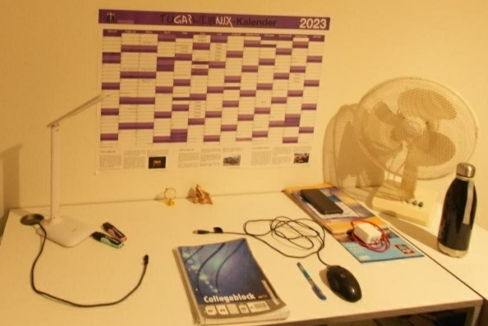

In [24]:
from utils import plot_points

prompt_text = """
    You are analyzing an image of a table with various objects.

    TASK: Locate every object that lies on the table surface, identify what each object is, and output point coordinates with descriptive labels in JSON format.

    COORDINATE SYSTEM:
    - Use NORMALIZED coordinates from 0 to 1
    - Origin (0,0) is TOP-LEFT corner of the image
    - (1,1) is BOTTOM-RIGHT corner
    - x: horizontal position (left to right)
    - y: vertical position (top to bottom)

    OBJECT IDENTIFICATION GUIDELINES:
    1. Be specific and descriptive in naming objects
    2. Use common English names (e.g., "coffee mug" not just "mug")
    3. For technical objects, use accurate terms (e.g., "Phillips screwdriver", "metric wrench")
    4. If uncertain, use general but descriptive terms (e.g., "electronic component", "metal bracket")
    5. Include size/color if it helps distinguish objects (e.g., "small red screw", "large black book")

    POINT PLACEMENT:
    - Place point at the visual center of each object
    - For irregular shapes, use the centroid
    - For objects with handles/extensions, focus on main body

    OUTPUT REQUIREMENTS:
    1. Return ONLY valid JSON array
    2. Each object must have: {"point_2d": [x, y], "label": "descriptive_name"}
    3. x and y MUST be between 0 and 1 (normalized)
    4. Include ALL objects on table surface
    5. Do NOT number labels like "object_1" - use descriptive names
    6. For multiple identical objects, add distinguishing features:
       - "blue pen" vs "black pen"
       - "hammer on left" vs "hammer on right"
       - "large notebook" vs "small notebook"

    IMPORTANT RULES:
    - Objects must be physically on the table surface
    - Ignore background objects, wall items, or floating objects
    - Do NOT use pixel coordinates - only normalized 0-1 range
    - If object is partially obscured, estimate its center

    EXAMPLE OUTPUT:
    ```json
    [
        {"point_2d": [0.324, 0.567], "label": "ceramic coffee mug"},
        {"point_2d": [0.412, 0.589], "label": "metal wrench"},
        {"point_2d": [0.538, 0.621], "label": "yellow pencil"},
        {"point_2d": [0.712, 0.489], "label": "smartphone"},
        {"point_2d": [0.823, 0.534], "label": "stack of papers"},
        {"point_2d": [0.456, 0.723], "label": "plastic water bottle"},
        {"point_2d": [0.389, 0.678], "label": "small silver screw"},
        {"point_2d": [0.645, 0.712], "label": "wooden ruler"}
    ]
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
plot_points(image_path, result)

JSON parse failed: Expecting value: line 1 column 1 (char 0)
Parsed bboxes:  []
Parsed descriptions:  []


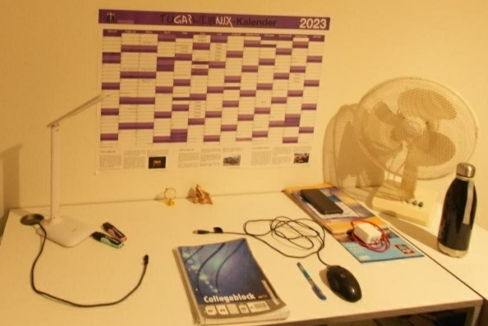

In [25]:
from utils import plot_bboxes


prompt_text = """
    You are analyzing an image of a table with various objects.

    TASK: Locate every object that lies on the table surface, identify what each object is, and output bounding box coordinates with descriptive labels in JSON format.

    COORDINATE SYSTEM:
    - Use NORMALIZED coordinates from 0 to 1
    - Origin (0,0) is TOP-LEFT corner of the image
    - (1,1) is BOTTOM-RIGHT corner
    - x: horizontal position (left to right)
    - y: vertical position (top to bottom)

    OBJECT IDENTIFICATION GUIDELINES:
    1. Be specific and descriptive in naming objects
    2. Use common English names (e.g., "coffee mug" not just "mug")
    3. For technical objects, use accurate terms (e.g., "Phillips screwdriver", "metric wrench")
    4. If uncertain, use general but descriptive terms (e.g., "electronic component", "metal bracket")
    5. Include size/color if it helps distinguish objects (e.g., "small red screw", "large black book")

    BOUNDING BOX PLACEMENT:
    - Define box as [x_min, y_min, x_max, y_max] — top-left to bottom-right corners
    - Cover the entire visible extent of the object on the table
    - For partially visible objects, estimate full bounding box based on visible portion
    - For stacked/overlapping objects, prioritize the most visible one

    OUTPUT REQUIREMENTS:
    1. Return ONLY valid JSON array
    2. Each object must have: {"bbox_2d": [x_min, y_min, x_max, y_max], "label": "descriptive_name"}
    3. All coordinates MUST be between 0 and 1 (normalized)
    4. Include ALL objects on table surface
    5. Do NOT number labels like "object_1" - use descriptive names
    6. For multiple identical objects, add distinguishing features:
       - "blue pen" vs "black pen"
       - "hammer on left" vs "hammer on right"
       - "large notebook" vs "small notebook"

    IMPORTANT RULES:
    - Objects must be physically on the table surface
    - Ignore background objects, wall items, or floating objects
    - Do NOT use pixel coordinates - only normalized 0-1 range
    - If object is partially obscured, estimate its full bounding box
    - DO NOT include wall calendars, figurines, or hanging decorations

    EXAMPLE OUTPUT:
    ```json
    [
        {"bbox_2d": [0.324, 0.567, 0.389, 0.621], "label": "ceramic coffee mug"},
        {"bbox_2d": [0.412, 0.589, 0.478, 0.635], "label": "metal wrench"},
        {"bbox_2d": [0.538, 0.621, 0.592, 0.654], "label": "yellow pencil"},
        {"bbox_2d": [0.712, 0.489, 0.789, 0.542], "label": "smartphone"},
        {"bbox_2d": [0.823, 0.534, 0.912, 0.598], "label": "stack of papers"},
        {"bbox_2d": [0.456, 0.723, 0.521, 0.789], "label": "plastic water bottle"},
        {"bbox_2d": [0.389, 0.678, 0.432, 0.712], "label": "small silver screw"},
        {"bbox_2d": [0.645, 0.712, 0.723, 0.756], "label": "wooden ruler"}
    ]
"""
image_path = "/home/jupyter/project/experiments/table.jpeg"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
plot_bboxes(image_path, result)

In [18]:
prompt_text = """
    You are an object detection and description assistant.
    
    IMAGE DESCRIPTION:
    - The image shows a table with multiple objects
    - Each object is marked with a visible red dot at its center
    - The red dots are your guide to locate ALL objects

    TASK:
    1. For EVERY red dot on the image, identify the corresponding object
    2. For each object, provide exactly 4 attributes in this format:
       [Object name], [main color], [size: small/medium/large], [position: left/center/right part of the table]

    DETECTION RULES:
    1. **Red dot priority**: Only process objects with red dots. Ignore objects without dots.
    2. **Object identification**: Determine the most specific name for each object (e.g., "screwdriver" not just "tool")
    3. **Color determination**: Identify the dominant/main color of the object
    4. **Size classification**:
       - Small: fits within 5% of image width
       - Medium: 5-15% of image width  
       - Large: >15% of image width
    5. **Position reference**: Use "table" as reference frame:
       - Left: left 1/3 of table area
       - Center: middle 1/3 of table area
       - Right: right 1/3 of table area

    OUTPUT FORMAT:
    - One line per object
    - Exactly: [Name], [Color], [Size], [Position]
    - Example: "Phillips screwdriver, red, medium, left part of the table"
    - List ALL objects in consistent order (e.g., left to right, top to bottom)

    SPECIAL CASES:
    1. **Dense clusters**: If dots are very close, analyze each separately
    2. **Overlapping objects**: Use the red dot position to determine which object
    3. **Uncertain objects**: Use best descriptive name (e.g., "electronic component" if unsure)
    4. **Multiple colors**: Choose the most prominent/visible color

    START DETECTION NOW. Return only the list, no explanations.
"""
image_path = "/home/jupyter/project/experiments/table_pointed.png"

result = generate_description(prompt_text, image_path, max_new_tokens=1024)
display(Markdown(result))

[Wall-mounted calendar, purple, large, center-top of the table], [Desk lamp, white, small, left side of the table], [USB drive, black, small, near the desk lamp], [Earphones, black, small, next to the USB drive], [Notebook, blue, medium, center-left of the table], [Pen, blue, small, lying on the notebook], [Computer mouse, black, small, right side of the table], [Mouse pad, yellow, small, under the computer mouse], [Fan, white, medium, right side of the table], [Water bottle, dark-colored, medium, far right of the table], [Keyboard, black, medium, partially covered by the mouse pad], [Laptop, silver, large, partially hidden behind the keyboard], [Calculator, black, small, left side of the table], [Stapler, gray, small, near the calculator], [Highlighter, red, small, near the calculator], [Post-it notes, yellow, small, near the calculator].
